# Permeability-related figures
This notebook reproduces result figures in the paper that came from the distributed diameter cases, with permeability effects only (Figure 6)

In [1]:
# First import the relevant packages and functions
from local_optim_fit import reorder_df, forge_axcaliber, fit_dict_axcaliber, fit_params
from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.core.acquisition_scheme import acquisition_scheme_from_qvalues,  acquisition_scheme_from_gradient_strengths
from dmipy.distributions import distribute_models

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit, minimize
import pandas as pd
from scipy.stats import gamma
from scipy.interpolate import CubicSpline, interp1d
from matplotlib.ticker import LinearLocator
import copy
import pickle

/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/utils/utils.py:6: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_cvxpy.py:8: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_tournier.py:6: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_plus.py:10: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in a

### Fit the raw data
We use two custom functions based on dmipy package and scipy to create our forward model -- the two-compartment model (`forge_axcaliber`), and fit the model to simulated data (`fit_params`).

In [3]:
# Create lists to store fitted parameters and fitting costs (squared errors)
costs = []
params = []

# Call the custom function to construct the forward model from interpolating simulated dictionary of intraaxonal signals at different radius values.
forward_model = forge_axcaliber()

# Loop through the relevant permeability values and fit the forward model to the total signal.
for perm in np.arange(0, 0.021, 0.001):
    
    # read the relevant signal file
    simdata = pd.read_csv("./perm_results/signal_MT_0_sus_0_perm_" + '{0:.3f}'.format(perm) + "_rmean_2.00_density_0.65.csv", header=None)
    y = simdata[2].to_numpy()/simdata[2][0] # and calculate the DW attenuation
    
    # Fit the model using the custom function which performs a least square fitting
    cost, param = fit_params(forward_model, y)
    # Store the fitting costs and fitted parameters in the correct lists
    costs.append(cost)
    params.append(param)

/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/scipy-1.15.1-py3.12-macosx-10.13-x86_64.egg/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/scipy-1.15.1-py3.12-macosx-10.13-x86_64.egg/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/scipy-1.15.1-py3.12-macosx-10.13-x86_64.egg/scipy/optimize/_diff

To skip fitting parameters from raw data, use the pre-fitted parameters

In [5]:
file_path = "precomputed_perm_params.pickle"
with open(file_path, 'rb') as file:
    params = pickle.load( file)

Read the fixed diameter case parameters for reference

In [17]:
file_path = "../fixed_diameter/precomputed_perm_params.pickle"
with open(file_path, 'rb') as file:
    param_sing = pickle.load( file)
# Extract the estimated diameter (nm_rfit_sing) and volume fraction (nm_vfit_sing) for an underlying diameter=5.4um ((0.3+24*0.1)*2) in fixed diameter case, we'll compare it to the distributed diameter case 
nm_rfit_sing = []
nm_vfit_sing = []
for i in range(21):
    nm_rfit_sing.append(param_sing[i][24]['Nelder-Mead'][2])
    nm_vfit_sing.append(param_sing[i][24]['Nelder-Mead'][0])

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.linewidth': 3})

### Figure 6a
Plot the fitted diameters across the range of permeability values.

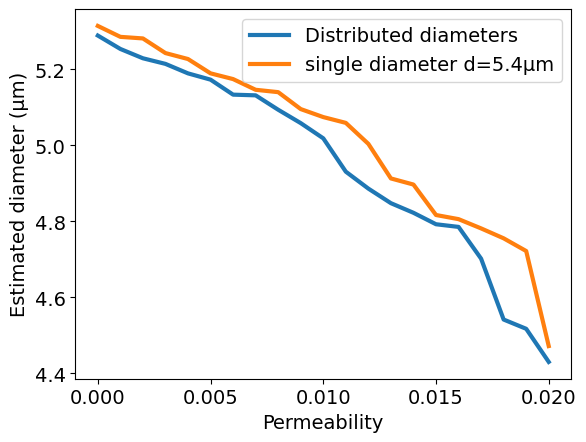

In [18]:
# Create a list to store fitted diameters
nm_rfit = []

# For each permeability value extract the fitted diameter (3rd sub element in the dictionary element)
for a in params:
    nm_rfit.append(a["Nelder-Mead"][2])

# Plot the fitted diameters across all permeability values
plt.plot(np.arange(0, 0.021, 0.001),np.array(nm_rfit)*2, label="Distributed diameters")
# Plot the fixed diameter case across all permeability values for reference
plt.plot(np.arange(0, 0.021, 0.001),np.array(nm_rfit_sing)*2, label="single diameter d=5.4μm")
plt.xlabel("Permeability")
plt.ylabel("Estimated diameter (μm)")
plt.legend()
plt.show()


### Figure 6b
Plot the fitted volume fractions across the range of permeability values

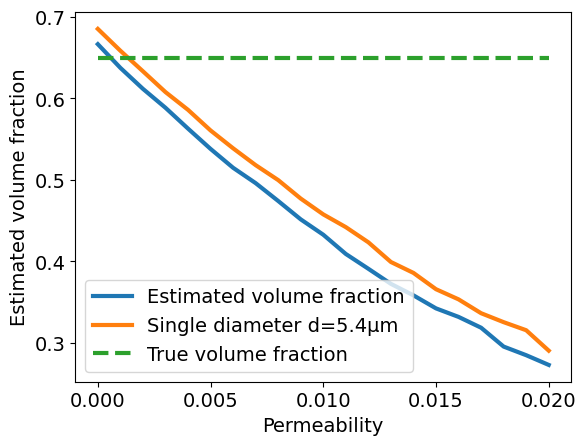

In [19]:
# Create a list to store fitted diameters
nm_vfit = []

# For each permeability value extract the fitted volume fraction (1st sub element in the dictionary element)
for a in params:
    nm_vfit.append(a["Nelder-Mead"][0])

# Plot the fitted volume fractions across all permeability values
plt.plot(np.arange(0, 0.021, 0.001),np.array(nm_vfit), label="Estimated volume fraction")
# Plot the fixed diameter case across all permeability values for reference
plt.plot(np.arange(0, 0.021, 0.001),np.array(nm_vfit_sing), label="Single diameter d=5.4μm")
# Plot the true underlying volume fraction 
plt.plot([0,0.02],[0.65,0.65], label="True volume fraction", linestyle="--")
plt.xlabel("Permeability")
plt.ylabel("Estimated volume fraction")
plt.legend(loc='lower left')
plt.show()
